This file implements a GRFP method on the data imported with SIDFiles. 

The code to implement such algorithm has been implemented by F.M.A. Mitrotta, and can be found in:

https://github.com/fmamitrotta/learn-aeroelastic-sid/blob/main/notebooks/04_Identification_of_a_2-DOF_Mass-Spring-Damper_System_with_the_RFP_Method.ipynb



In [2]:
import numpy as np


def generate_orthogonal_polynomials(omegas, order, weights):
    """
    Generate orthogonal polynomials using the Forsythe method and build the conversion matrix
    to map from orthogonal polynomial coefficients to ordinary polynomial coefficients.

    Parameters:
    omegas (array): Frequency points (real-valued)
    order (int): Maximum order of polynomials to generate
    weights (array): Weighting function values at each frequency point

    Returns:
    tuple: (
        complex_F: Complex orthogonal polynomials with shape (len(omegas), order+1),
        Gamma: Conversion matrix with shape (order+1, order+1) that maps from orthogonal
           to ordinary polynomial coefficients
    )
    """
    # Find number of frequency points
    n_frequencies = len(omegas)

    # Initialize array to store polynomials
    complex_F = np.zeros((n_frequencies, order + 1), dtype=complex)
    F = np.zeros((n_frequencies, order + 1), dtype=float)
    G = np.zeros((n_frequencies, order + 1), dtype=float)
    V = np.zeros(order + 1, dtype=float)

    # Initialize conversion matrix Gamma
    # Gamma[k,j] = coefficient of s^j in the k-th orthogonal polynomial
    Gamma = np.zeros((order + 1, order + 1))

    # coeff_arrays is a list of arrays, where each array represents one orthogonal polynomial in terms of powers of s
    # coeff_arrays[k] contains the coefficients of the k-th orthogonal polynomial φₖ(s)
    # coeff_arrays[k][j] holds the coefficient of s^j in the expansion of φₖ(s)
    coeff_arrays = [np.zeros(order + 1) for _ in range(order + 1)]

    # Calculate polynomials for k=0
    p0 = 1.0 / np.sqrt(np.sum(weights))  # coefficient for φ₀(s)
    F[:, 0] = p0  # for k=0 the orthogonal polynomial is constant
    complex_F[:, 0] = F[:, 0] * (1j**0)

    # Assign value of the coefficient of s^0 in φ₀(s)
    coeff_arrays[0][0] = p0
    Gamma[0, 0] = p0

    # Calculate polynomials for k=1
    G[:, 1] = omegas * F[:, 0]  # F[:,-1]=0, V[0]=0
    norm_factor = np.sqrt(np.sum(G[:, 1] ** 2 * weights))
    F[:, 1] = G[:, 1] / norm_factor
    complex_F[:, 1] = F[:, 1] * (1j**1)

    # For k=1, the orthogonal polynomial is p1*s
    p1 = p0 / norm_factor
    coeff_arrays[1][1] = p1  # coefficient of s^1 in φ₁(s)
    Gamma[1, 1] = p1

    # Iterate from k=2 to k=order
    for k in range(2, order + 1):
        # Calculate V[k-1]
        V[k - 1] = np.sum(omegas * F[:, k - 1] * F[:, k - 2] * weights)

        # Calculate G[:, k]
        G[:, k] = omegas * F[:, k - 1] - V[k - 1] * F[:, k - 2]

        # Calculate norm_factor
        norm_factor = np.sqrt(np.sum(G[:, k] ** 2 * weights))

        # Calculate F[:, k]
        F[:, k] = G[:, k] / norm_factor

        # Calculate complex polynomials
        complex_F[:, k] = F[:, k] * (1j**k)

        # Update coefficient arrays for this orthogonal polynomial
        # φₖ(s) = (s*φₖ₋₁(s) - V[k-1]*φₖ₋₂(s)) / norm_factor

        # First part: s*φₖ₋₁(s) -> shift coefficients up by one power of s
        temp_coeffs = np.zeros(
            order + 1
        )  # holds intermediate calculation before normalization
        for i in range(order):
            temp_coeffs[i + 1] = coeff_arrays[k - 1][i]

        # Second part: subtract V[k-1]*φₖ₋₂(s)
        for i in range(order + 1):
            temp_coeffs[i] -= V[k - 1] * coeff_arrays[k - 2][i]

        # Normalize
        coeff_arrays[k] = temp_coeffs / norm_factor

        # Update conversion matrix Gamma with these coefficients
        Gamma[k, :] = coeff_arrays[k]

    # Return the complex orthogonal polynomials and the conversion matrix
    return complex_F, Gamma


def test_orthogonality(phi, weights):
    """
    Test the orthogonality of the generated polynomials.

    Parameters:
    phi (array): Generated orthogonal polynomials
    weights (array): Weighting function values at each frequency point
    """
    # Find maximum order of polynomials
    order = phi.shape[1] - 1

    # Loop through each pair of polynomial orders
    for j in range(order + 1):
        for k in range(
            j + 1
        ):  # Only need to check half due to symmetry of inner product
            # Calculate inner product
            inner_product = np.sum(np.conj(phi[:, j]) * phi[:, k] * weights)

            # Print results and expected values
            expected = "non-zero" if j == k else "zero"
            print(
                f"j={j}, k={k}, j+k={j+k}: {inner_product:.10f} (expected: {expected})"
            )


# Test 1: Only positive frequencies
order = 4
frequencies1 = np.linspace(0.01, 10, 100)  # Avoid zero
weighting1 = np.ones_like(frequencies1)
phi1, _ = generate_orthogonal_polynomials(frequencies1, order, weighting1)
print("Test 1: Positive frequencies only")
test_orthogonality(phi1, weighting1)

Test 1: Positive frequencies only
j=0, k=0, j+k=0: 1.0000000000+0.0000000000j (expected: non-zero)
j=1, k=0, j+k=1: 0.0000000000-0.8642846120j (expected: zero)
j=1, k=1, j+k=2: 1.0000000000+0.0000000000j (expected: non-zero)
j=2, k=0, j+k=2: 0.0000000000+0.0000000000j (expected: zero)
j=2, k=1, j+k=3: 0.0000000000-0.4867899829j (expected: zero)
j=2, k=2, j+k=4: 1.0000000000+0.0000000000j (expected: non-zero)
j=3, k=0, j+k=3: 0.0000000000-0.3300482923j (expected: zero)
j=3, k=1, j+k=4: 0.0000000000+0.0000000000j (expected: zero)
j=3, k=2, j+k=5: 0.0000000000-0.7361771682j (expected: zero)
j=3, k=3, j+k=6: 1.0000000000+0.0000000000j (expected: non-zero)
j=4, k=0, j+k=4: -0.0000000000+0.0000000000j (expected: zero)
j=4, k=1, j+k=5: 0.0000000000-0.1094381826j (expected: zero)
j=4, k=2, j+k=6: 0.0000000000+0.0000000000j (expected: zero)
j=4, k=3, j+k=7: 0.0000000000-0.5618747111j (expected: zero)
j=4, k=4, j+k=8: 1.0000000000+0.0000000000j (expected: non-zero)


In [3]:
def generate_orthogonal_polynomials(omegas, order, weights):
    """
    Generate orthogonal polynomials using the Forsythe method and build the conversion matrix
    to map from orthogonal polynomial coefficients to ordinary polynomial coefficients.

    Parameters:
    omegas (array): Frequency points (real-valued)
    order (int): Maximum order of polynomials to generate
    weights (array): Weighting function values at each frequency point

    Returns:
    tuple: (
        complex_F: Complex orthogonal polynomials with shape (len(omegas), order+1),
        Gamma: Conversion matrix with shape (order+1, order+1) that maps from orthogonal
           to ordinary polynomial coefficients
    )
    """
    # Find number of frequency points
    n_frequencies = len(omegas)

    # Initialize array to store polynomials
    complex_F = np.zeros((n_frequencies, order + 1), dtype=complex)
    F = np.zeros((n_frequencies, order + 1), dtype=float)
    G = np.zeros((n_frequencies, order + 1), dtype=float)
    V = np.zeros(order + 1, dtype=float)

    # Initialize conversion matrix Gamma
    # Gamma[k,j] = coefficient of s^j in the k-th orthogonal polynomial
    Gamma = np.zeros((order + 1, order + 1))

    # coeff_arrays is a list of arrays, where each array represents one orthogonal polynomial in terms of powers of s
    # coeff_arrays[k] contains the coefficients of the k-th orthogonal polynomial φₖ(s)
    # coeff_arrays[k][j] holds the coefficient of s^j in the expansion of φₖ(s)
    coeff_arrays = [np.zeros(order + 1) for _ in range(order + 1)]

    # Calculate polynomials for k=0
    p0 = 1.0 / np.sqrt(np.sum(weights))  # coefficient for φ₀(s)
    F[:, 0] = p0  # for k=0 the orthogonal polynomial is constant
    complex_F[:, 0] = F[:, 0] * (1j**0)

    # Assign value of the coefficient of s^0 in φ₀(s)
    coeff_arrays[0][0] = p0
    Gamma[0, 0] = p0

    # Calculate polynomials for k=1
    G[:, 1] = omegas * F[:, 0]  # F[:,-1]=0, V[0]=0
    norm_factor = np.sqrt(np.sum(G[:, 1] ** 2 * weights))
    F[:, 1] = G[:, 1] / norm_factor
    complex_F[:, 1] = F[:, 1] * (1j**1)

    # For k=1, the orthogonal polynomial is p1*s
    p1 = p0 / norm_factor
    coeff_arrays[1][1] = p1  # coefficient of s^1 in φ₁(s)
    Gamma[1, 1] = p1

    # Iterate from k=2 to k=order
    for k in range(2, order + 1):
        # Calculate V[k-1]
        V[k - 1] = np.sum(omegas * F[:, k - 1] * F[:, k - 2] * weights)

        # Calculate G[:, k]
        G[:, k] = omegas * F[:, k - 1] - V[k - 1] * F[:, k - 2]

        # Calculate norm_factor
        norm_factor = np.sqrt(np.sum(G[:, k] ** 2 * weights))

        # Calculate F[:, k]
        F[:, k] = G[:, k] / norm_factor

        # Calculate complex polynomials
        complex_F[:, k] = F[:, k] * (1j**k)

        # Update coefficient arrays for this orthogonal polynomial
        # φₖ(s) = (s*φₖ₋₁(s) - V[k-1]*φₖ₋₂(s)) / norm_factor

        # First part: s*φₖ₋₁(s) -> shift coefficients up by one power of s
        temp_coeffs = np.zeros(
            order + 1
        )  # holds intermediate calculation before normalization
        for i in range(order):
            temp_coeffs[i + 1] = coeff_arrays[k - 1][i]

        # Second part: subtract V[k-1]*φₖ₋₂(s)
        for i in range(order + 1):
            temp_coeffs[i] -= V[k - 1] * coeff_arrays[k - 2][i]

        # Normalize
        coeff_arrays[k] = temp_coeffs / norm_factor

        # Update conversion matrix Gamma with these coefficients
        Gamma[k, :] = coeff_arrays[k]

    # Return the complex orthogonal polynomials and the conversion matrix
    return complex_F, Gamma

In [4]:
def grfp_curve_fit(frequencies, frfs, numerator_order, denominator_order):
    """
    Implements the Global Rational Fraction Polynomial (GRFP) method for curve fitting
    multiple FRF measurements simultaneously.

    Parameters:
    ----------
    frequencies : ndarray
        Array of frequency points (should be a set of symmetric frequencies around zero)
    frfs : ndarray
        Array of FRF measurements with shape (n_dofs, n_frequencies)
    numerator_order : int
        Order of the numerator polynomial
    denominator_order : int
        Order of the denominator polynomial

    Returns:
    -------
    tuple
        - a_coeffs: List of numerator ordinary polynomial coefficients for each DOF
        - b_coeffs: Denominator ordinary polynomial coefficients
    """
    # Find number of response FRFs and frequency points
    n_dofs = frfs.shape[0]
    n_freqs = frequencies.shape[0]

    # Create weights for polynomials
    # For numerator: uniform weighting
    numerator_weights = np.ones_like(frequencies)

    # For denominator: sum of squared magnitudes of all FRFs
    denominator_weights = np.sum(np.abs(frfs) ** 2, axis=0)

    # Generate numerator orthogonal polynomials
    phi, Gamma_numerator = generate_orthogonal_polynomials(
        frequencies, numerator_order, numerator_weights
    )

    # Generate denominator orthogonal polynomials
    theta, Gamma_denominator = generate_orthogonal_polynomials(
        frequencies, denominator_order, denominator_weights
    )

    # Setup matrices for the squared-error minimization problem
    D_T_list = []  # D_T,j matrices
    X_list = []  # X_j matrices
    H_list = []  # H_j vectors

    # Loop through each degree of freedom
    for j in range(n_dofs):
        # Calculate T_j matrix
        T_j = (
            theta[:, :-1] * frfs[j][:, np.newaxis]
        )  # Broadcasting to create T_j matrix

        # Calculate D_T,j matrix
        D_T_j = np.diag(
            np.sum(np.abs(T_j) ** 2, axis=0)
        )  # Diagonal matrix of sum of squares along frequency points
        D_T_list.append(D_T_j)

        # Calculate X_j matrix
        X_j = -np.real(phi.conj().T @ T_j)
        X_list.append(X_j)

        # Calculate W_j vector
        W_j = frfs[j] * theta[:, -1]

        # Calculate H_j vector
        H_j = np.real(phi.conj().T @ W_j)
        H_list.append(H_j)

    # Calculate left and right-hand sides of the linear system for the denominator coefficients
    LHS = np.sum([D_Tj for D_Tj in D_T_list], axis=0) - np.sum(
        [X_j.T @ X_j for X_j in X_list], axis=0
    )
    RHS = -np.sum([X_j.T @ H_j for X_j, H_j in zip(X_list, H_list)], axis=0)

    # Solve for denominator coefficients d
    D = np.linalg.solve(LHS, RHS)

    # Add the last coefficient (d_n = 1)
    d_coeffs = np.append(D, 1)

    # Convert orthogonal denominator coefficients to ordinary denominator coefficients
    b_coeffs = np.zeros(denominator_order + 1, dtype=complex)
    for i in range(denominator_order + 1):
        b_coeffs[i] = np.sum(
            d_coeffs[i:]
            * Gamma_denominator[i:, i]
            * 1j ** (np.arange(denominator_order + 1 - i))
        )

    # Calculate numerator coefficients c_j for each DOF and convert to ordinary coefficients
    # Initialize lists for coefficients
    a_coeffs_list = []
    c_coeffs_list = []

    # Loop through each degree of freedom
    for j in range(n_dofs):
        # Find orthogonal coefficients
        C_j = H_list[j] - X_list[j] @ D
        c_coeffs_list.append(C_j)

        # Convert orthogonal coefficients to ordinary coefficients
        a_coeffs_list.append(np.zeros(numerator_order + 1, dtype=complex))
        for i in range(numerator_order + 1):
            a_coeffs_list[j][i] = np.sum(
                c_coeffs_list[j][i:]
                * Gamma_numerator[i:, i]
                * 1j ** (np.arange(numerator_order + 1 - i))
            )

    # Return the coefficients and conversion matrices
    return a_coeffs_list, b_coeffs, c_coeffs_list, d_coeffs, phi, theta

In [ ]:
from scipy.io import loadmat
import numpy as np
# Select numerator and denominator orders
numerator_order = 2
denominator_order = 4

f_sampling = 100

data = loadmat("SIDFiles.mat")
frequencies = data["frequencies"].flatten()
frfs = data["frfs"].reshape(2,256)


# Take symmetric frequency points around zero (exclude Nyquist frequency point)
symmetric_mask = np.abs(frequencies) < f_sampling / 2
symmetric_angular_frequencies = 2 * np.pi * frequencies[symmetric_mask]

# Perform global curve fitting
a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
    symmetric_angular_frequencies, frfs[:, symmetric_mask], numerator_order, denominator_order)

In [6]:
import matplotlib.pyplot as plt  # import matplotlib library for plotting

def plot_spectrum(
    frequencies, spectrum, unwrap=False, axes=None, label=None, title=None
):
    """Plot magnitude and phase spectrum of a signal

    Parameters:
    frequencies (array): Frequency vector of full spectrum (positive and negative frequencies)
    spectrum (array): Complex spectrum values
    unwrap (bool): Unwrap phase if True (optional)
    axes (array): Axes to plot on (optional)
    label (str): Label for the plot (optional)
    title (str): Plot title (optional)
    """
    # Get positive frequencies only (since spectrum is symmetric for real signals)
    pos_mask = frequencies >= 0
    pos_freqs = frequencies[pos_mask]
    pos_spectrum = spectrum[pos_mask]

    # Calculate magnitude in dB and phase in radians
    magnitude_db = 20 * np.log10(np.abs(pos_spectrum))
    phase = np.angle(pos_spectrum)

    # Unwrap phase if specified
    if unwrap:
        phase = np.unwrap(phase)

    # Convert phase to degrees
    phase = np.rad2deg(phase)

    # Create figure with two subplots if axes are not provided
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    else:
        fig = axes[0].figure

    # Plot magnitude
    axes[0].plot(pos_freqs, magnitude_db, label=label)
    axes[0].set_ylabel("Magnitude")
    axes[0].grid(True)

    # Plot phase
    axes[1].plot(pos_freqs, phase)
    axes[1].set_ylabel("Phase, deg")
    axes[1].set_xlabel("Frequency, Hz")
    axes[1].grid(True)

    # Set title if provided
    if title:
        axes[0].set_title(f"{title} Magnitude Spectrum")
        axes[1].set_title(f"{title} Phase Spectrum")

    # Return figure and axes for further customization if needed
    return fig, axes

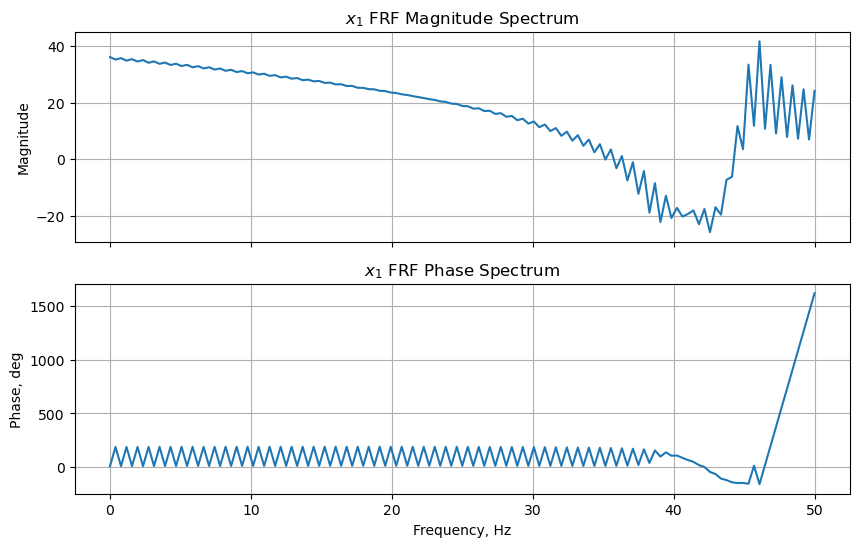

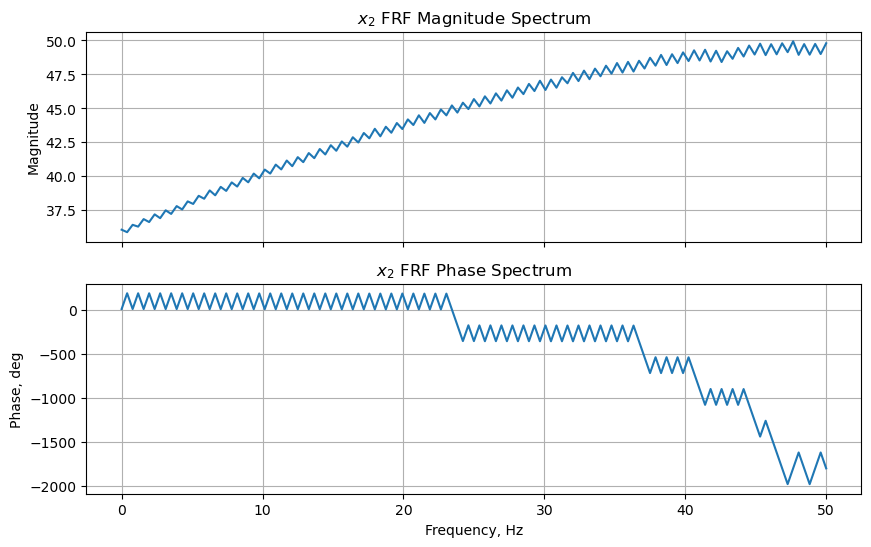

In [11]:
import matplotlib.pyplot as plt  # import matplotlib library for plotting

_, _ = plot_spectrum(frequencies, frfs[0,:], unwrap=True, title="$x_1$ FRF")
plt.show()
_, _ = plot_spectrum(frequencies, frfs[1,:], unwrap=True, title="$x_2$ FRF")
plt.show()
